### Read in the Data

In [78]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn import linear_model, svm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

train=pd.read_csv('oversample_train.csv')
train=train.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)

valid=pd.read_csv('oversample_validation.csv')
valid=valid.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)


### Check for correct oversampling

In [79]:
print(len(train), len(valid))
print(sum(train['Claim_Flag']), sum(valid['Claim_Flag']))


99275 43107
50192 21511


### Gradient Boosting Model


In [80]:
gboost = GradientBoostingClassifier()
gboost.fit(train[train.columns.difference(['Claim_Flag'])], train['Claim_Flag'])

predict_train_gb = gboost.predict_proba(train[train.columns.difference(['Claim_Flag'])])[:,1]
predict_validation_gb = gboost.predict_proba(valid[valid.columns.difference(['Claim_Flag'])])[:,1]

train_matrix=confusion_matrix(train['Claim_Flag'], (predict_train_gb>.49).astype(float))
print(train_matrix)
print('\n',100*round((train_matrix[0,0]+train_matrix[1,1])/len(train['Claim_Flag']),3),"Accuracy of model - Gradient Boost Train","\n")

validation_matrix=confusion_matrix(valid['Claim_Flag'], (predict_validation_gb>.49).astype(float))
print(validation_matrix)
print('\n',100*round((validation_matrix[0,0]+validation_matrix[1,1])/len(valid['Claim_Flag']),3),"Accuracy of model - Gradient Boost Validation")


[[26380 22703]
 [18880 31312]]

 58.1 Accuracy of model - Gradient Boost Train 

[[11399 10197]
 [ 8294 13217]]

 57.1 Accuracy of model - Gradient Boost Validation


### Logistic Regression

In [81]:
regression = linear_model.LogisticRegression(C=1)
regression.fit(train[train.columns.difference(['Claim_Flag'])], train['Claim_Flag'])

predict_train_lm = regression.predict_proba(train[train.columns.difference(['Claim_Flag'])])[:,1]
predict_validation_lm = regression.predict_proba(valid[valid.columns.difference(['Claim_Flag'])])[:,1]
                                                    
train_matrix=confusion_matrix(train['Claim_Flag'], (predict_train_lm>.49).astype(float))
print(train_matrix)
print('\n',100*round((train_matrix[0,0]+train_matrix[1,1])/len(train['Claim_Flag']),3),"Accuracy of model - Logistic Regression Train","\n")

#Confusion Matrix for Validation
validation_matrix=confusion_matrix(valid['Claim_Flag'], (predict_validation_lm>.49).astype(float))
print(validation_matrix)
print('\n',100*round((validation_matrix[0,0]+validation_matrix[1,1])/len(valid['Claim_Flag']),3),"Accuracy of model - Logistic Regression Validation", "\n")



[[26446 22637]
 [19874 30318]]

 57.2 Accuracy of model - Logistic Regression Train 

[[11687  9909]
 [ 8575 12936]]

 57.1 Accuracy of model - Logistic Regression Validation 



### Optimize the number of paramaters random forest

In [82]:
rforest=RandomForestClassifier(n_estimators=50,oob_score=True, max_depth=10, min_samples_leaf=5)

oob_score=[]
for i in range(5, 20): #3, 16
    rforest.set_params(max_features=i)
    rforest.fit(train[train.columns.difference(['Claim_Flag'])], train['Claim_Flag'])
    oob_score.append(rforest.oob_score_)
  

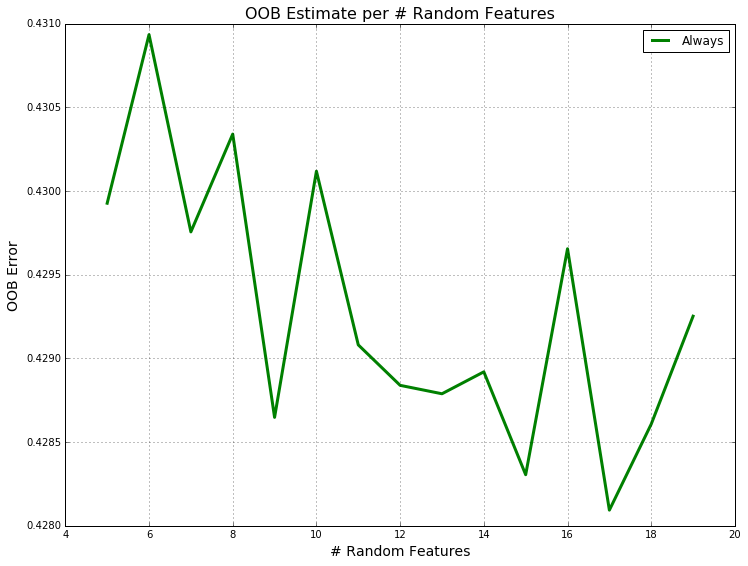

In [83]:
oob_error=1-np.array(oob_score)  #can also use list(map(lambda x: 1-x,oob_score)) 
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
ax.plot(list(range(5,20)),oob_error,lw=3, label='Always', color='green')
ax.set_xlabel("# Random Features",size=14)
ax.set_ylabel("OOB Error",size=14)
ax.legend(loc='best')
plt.title("OOB Estimate per # Random Features", size=16)
plt.grid(True)
plt.show()

In [84]:
rforest=RandomForestClassifier(oob_score=True, max_depth=10, min_samples_leaf=5)

trees=np.arange(50,500,50)
oob_score=[]
for i in trees: #3, 16
    rforest.set_params(n_estimators=i)
    rforest.fit(train[train.columns.difference(['Claim_Flag'])], train['Claim_Flag'])
    oob_score.append(rforest.oob_score_)

    

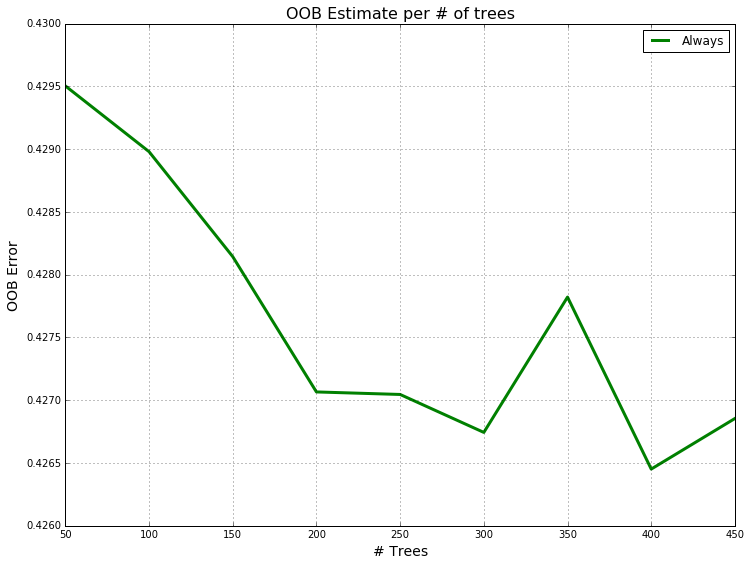

In [90]:
#oob_error=list(map(lambda x: 1-x,oob_score))
oob_error=1-np.array(oob_score)
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
ax.plot(trees,oob_error,lw=3, label='Always', color='green')
ax.set_xlabel("# Trees",size=14)
ax.set_ylabel("OOB Error",size=14)
ax.legend(loc='best')
plt.title("OOB Estimate per # of trees", size=16)
plt.grid(True)
plt.show()

### Random Forest

In [86]:
rforest = RandomForestClassifier(n_estimators=200,oob_score=True, max_depth=10, min_samples_leaf=5) #50
rforest.fit(train[train.columns.difference(['Claim_Flag'])], train['Claim_Flag'])

predict_train_rf = rforest.predict_proba(train[train.columns.difference(['Claim_Flag'])])[:,1]
predict_validation_rf = rforest.predict_proba(valid[valid.columns.difference(['Claim_Flag'])])[:,1]

train_matrix=confusion_matrix(train['Claim_Flag'], (predict_train_rf>.49).astype(float))
print(train_matrix)
print('\n',100*round((train_matrix[0,0]+train_matrix[1,1])/len(train['Claim_Flag']),3),"Accuracy of model - Random Forest Train","\n")

validation_matrix=confusion_matrix(valid['Claim_Flag'], (predict_validation_rf>.49).astype(float))
print(validation_matrix)
print('\n',100*round((validation_matrix[0,0]+validation_matrix[1,1])/len(valid['Claim_Flag']),3),"Accuracy of model - Random Forest Validation")



[[27584 21499]
 [17577 32615]]

 60.6 Accuracy of model - Random Forest Train 

[[11331 10265]
 [ 8243 13268]]

 57.1 Accuracy of model - Random Forest Validation


### OOB Score

In [87]:
print(rforest.oob_score_)


0.573407202216


### ROC Curve Setup

In [88]:
#Logistic Roc
lr_roc=roc_auc_score(valid['Claim_Flag'], predict_validation_lm)

#Roc for GB
gb_roc=roc_auc_score(valid['Claim_Flag'], predict_validation_gb)

#RF Roc
rf_roc=roc_auc_score(valid['Claim_Flag'], predict_validation_rf)


#Stats needed to create ROC graph below
fpr_lr, tpr_lr, thresholds_lr=roc_curve(valid['Claim_Flag'], predict_validation_lm)
fpr_gb, tpr_gb, thresholds_gb=roc_curve(valid['Claim_Flag'], predict_validation_gb)
fpr_rf, tpr_rf, thresholds_rf=roc_curve(valid['Claim_Flag'], predict_validation_rf)


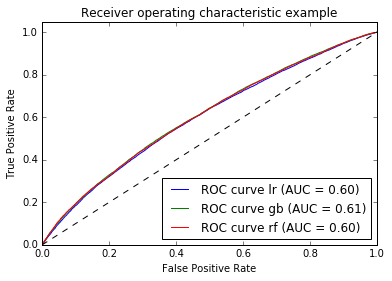

In [89]:
plt.figure()

plt.plot(fpr_lr, tpr_lr, label='ROC curve lr (AUC = %0.2f)' % lr_roc)
plt.plot(fpr_gb, tpr_gb, label='ROC curve gb (AUC = %0.2f)' % gb_roc)
plt.plot(fpr_rf, tpr_rf, label='ROC curve rf (AUC = %0.2f)' % rf_roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()